# **Stage 1**

# **Importing Libraries**

In [1]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.6.2', '1.20.3')

In [2]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
import os
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout,Flatten ,LeakyReLU
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler ,ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier

from skimage import feature, filters, io, color
from skimage.transform import resize
from skimage.feature import canny
from skimage.filters import sobel
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
tf.__version__, np.__version__

('2.6.2', '1.20.3')

# **Data Reading** 

In [4]:
def load_images_and_create_map(directory, plant_type_mapping):
    img_label_map = {}

    label_encoder = LabelEncoder()
    label_encoder.fit(list(plant_type_mapping.keys()))


    for plant_type, disease_folders in plant_type_mapping.items():

        for disease_folder in disease_folders:
            disease_folder_path = os.path.join(directory, disease_folder)

            for img_name in os.listdir(disease_folder_path):
                img_path = os.path.join(disease_folder_path, img_name)

                if os.path.isfile(img_path):

                    label = label_encoder.transform([plant_type])[0]

                    img_label_map[img_path] = label

    return img_label_map

# change this with you path on drive
train_dir = '/kaggle/input/data-vision2/Project Data/Train/images/'
val_dir = '/kaggle/input/data-vision2/Project Data/Val/images/'

plant_type_mapping = {
    "Apple": ["Apple___Apple_scab", "Apple___Black_rot", "Apple___Cedar_apple_rust", "Apple___healthy"],
    "Cherry_(including_sour)": ["Cherry_(including_sour)___healthy", "Cherry_(including_sour)___Powdery_mildew"],
    "Corn_(maize)": ["Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", "Corn_(maize)___Common_rust_", "Corn_(maize)___healthy", "Corn_(maize)___Northern_Leaf_Blight"],
    "Grape": ["Grape___Black_rot", "Grape___Esca_(Black_Measles)", "Grape___healthy", "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)"],
    "Peach": ["Peach___Bacterial_spot", "Peach___healthy"],
    "Pepper,_bell": ["Pepper,_bell___Bacterial_spot", "Pepper,_bell___healthy"],
    "Potato": ["Potato___Early_blight", "Potato___healthy", "Potato___Late_blight"],
    "Strawberry": ["Strawberry___healthy", "Strawberry___Leaf_scorch"],
    "Tomato": ["Tomato___Bacterial_spot", "Tomato___Early_blight", "Tomato___healthy", "Tomato___Late_blight",
               "Tomato___Leaf_Mold", "Tomato___Septoria_leaf_spot", "Tomato___Spider_mites Two-spotted_spider_mite",
               "Tomato___Target_Spot", "Tomato___Tomato_mosaic_virus", "Tomato___Tomato_Yellow_Leaf_Curl_Virus"]
}

train_img_label_map = load_images_and_create_map(train_dir, plant_type_mapping)
print("Training dataset mapping length:", len(train_img_label_map))

val_img_label_map = load_images_and_create_map(val_dir, plant_type_mapping)
print("Validation dataset mapping length:", len(val_img_label_map))

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return img_array

train_images = np.array([preprocess_image(img_path) for img_path in train_img_label_map.keys()])
train_labels = np.array(list(train_img_label_map.values()))
print(train_images.shape)

val_images = np.array([preprocess_image(img_path) for img_path in val_img_label_map.keys()])
val_labels = np.array(list(val_img_label_map.values()))
print(val_labels.shape)

train_labels = to_categorical(train_labels, num_classes=9)
val_labels = to_categorical(val_labels, num_classes=9)
print(train_labels.shape)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_datagen.fit(train_images)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_labels, batch_size=64)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=64)

print("done")

Training dataset mapping length: 1320
Validation dataset mapping length: 330
(1320, 256, 256, 3)
(330,)
(1320, 9)
done


In [61]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.utils import to_categorical

train_generator_labels = np.argmax(train_labels, axis=1) 
# Step 2: Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Automatically balance class weights
    classes=np.unique(train_generator_labels),  # Unique class indices
    y=train_generator_labels  # List of all class labels
)

# Step 3: Convert to dictionary format
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weights_dict)

Computed Class Weights: {0: 0.9166666666666666, 1: 1.8333333333333333, 2: 0.9166666666666666, 3: 0.9166666666666666, 4: 1.8333333333333333, 5: 1.8333333333333333, 6: 1.2222222222222223, 7: 1.8333333333333333, 8: 0.36666666666666664}


# **Models**

# **Deep Learning Models**

# **DenseNet121**

best model in classificaton

In [63]:
# Model Definition
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

loaded_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dense(9, activation='softmax', kernel_regularizer='l2')
])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Compile
loaded_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = loaded_model.fit(train_generator, validation_data=val_generator, epochs=20, batch_size = 256, callbacks=[early_stop, reduce_lr])

print("\nFinal Training and Validation Accuracy for DenseNet121:")
for epoch, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), 1):
    print(f"Epoch {epoch}: Training Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

# Evaluate
train_loss, train_acc = loaded_model.evaluate(train_generator)
val_loss, val_acc = loaded_model.evaluate(val_generator)
print(f"Final Training Accuracy: {train_acc:.4f}, Final Validation Accuracy: {val_acc:.4f}")


Epoch 1/20
21/21 [==============================] - 30s 1s/step - loss: 11.7315 - accuracy: 0.4500 - val_loss: 11.1173 - val_accuracy: 0.5424
Epoch 2/20
21/21 [==============================] - 21s 1s/step - loss: 10.1292 - accuracy: 0.8167 - val_loss: 10.1993 - val_accuracy: 0.6788
Epoch 3/20
21/21 [==============================] - 21s 1s/step - loss: 9.3266 - accuracy: 0.8947 - val_loss: 9.4143 - val_accuracy: 0.8364
Epoch 4/20
21/21 [==============================] - 22s 1s/step - loss: 8.7037 - accuracy: 0.9273 - val_loss: 8.7353 - val_accuracy: 0.9061
Epoch 5/20
21/21 [==============================] - 21s 1s/step - loss: 8.1480 - accuracy: 0.9447 - val_loss: 8.1496 - val_accuracy: 0.9303
Epoch 6/20
21/21 [==============================] - 22s 1s/step - loss: 7.6664 - accuracy: 0.9515 - val_loss: 7.6199 - val_accuracy: 0.9515
Epoch 7/20
21/21 [==============================] - 21s 999ms/step - loss: 7.2264 - accuracy: 0.9553 - val_loss: 7.1449 - val_accuracy: 0.9606
Epoch 8/20
21

In [64]:
loaded_model.save('new_model.h5')
# model.save_weights("classification_model.h5")
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_8 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_13 (Dense)             (None, 9)                 9225      
Total params: 8,100,425
Trainable params: 1,060,873
Non-trainable params: 7,039,552
_________________________________________________________________


# **Xception**

In [65]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(9, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1)

print("\nFinal Training and Validation Accuracy for Xception:")
for epoch, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), 1):
    print(f"Epoch {epoch}: Training Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nFinal Training Accuracy: {train_acc:.4f}, Final Validation Accuracy: {val_acc:.4f}")


83697664/83683744 [==============================] - 3s 0us/step
Epoch 1/10
21/21 [==============================] - 26s 1s/step - loss: 1.6752 - accuracy: 0.4409 - val_loss: 1.2943 - val_accuracy: 0.6485
Epoch 2/10
21/21 [==============================] - 22s 1s/step - loss: 1.1081 - accuracy: 0.6705 - val_loss: 0.9113 - val_accuracy: 0.7788
Epoch 3/10
21/21 [==============================] - 22s 1s/step - loss: 0.8162 - accuracy: 0.7735 - val_loss: 0.7112 - val_accuracy: 0.8424
Epoch 4/10
21/21 [==============================] - 22s 1s/step - loss: 0.6635 - accuracy: 0.8212 - val_loss: 0.5941 - val_accuracy: 0.8576
Epoch 5/10
21/21 [==============================] - 22s 1s/step - loss: 0.5491 - accuracy: 0.8689 - val_loss: 0.4897 - val_accuracy: 0.8848
Epoch 6/10
21/21 [==============================] - 22s 1s/step - loss: 0.4844 - accuracy: 0.8720 - val_loss: 0.4157 - val_accuracy: 0.8909
Epoch 7/10
21/21 [==============================] - 22s 1s/step - loss: 0.4250 - accuracy: 0.89

# **MobileNetV1**

In [66]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(9, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=10)

val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc}")


Epoch 1/10
21/21 [==============================] - 24s 1s/step - loss: 1.5869 - accuracy: 0.4652 - val_loss: 1.1327 - val_accuracy: 0.7212
Epoch 2/10
21/21 [==============================] - 21s 1s/step - loss: 0.8717 - accuracy: 0.7803 - val_loss: 0.7090 - val_accuracy: 0.8515
Epoch 3/10
21/21 [==============================] - 21s 991ms/step - loss: 0.5603 - accuracy: 0.8811 - val_loss: 0.5660 - val_accuracy: 0.8636
Epoch 4/10
21/21 [==============================] - 21s 1s/step - loss: 0.4268 - accuracy: 0.8992 - val_loss: 0.4486 - val_accuracy: 0.8909
Epoch 5/10
21/21 [==============================] - 21s 1s/step - loss: 0.3476 - accuracy: 0.9303 - val_loss: 0.3647 - val_accuracy: 0.9212
Epoch 6/10
21/21 [==============================] - 21s 1s/step - loss: 0.3003 - accuracy: 0.9348 - val_loss: 0.3048 - val_accuracy: 0.9394
Epoch 7/10
21/21 [==============================] - 21s 985ms/step - loss: 0.2526 - accuracy: 0.9492 - val_loss: 0.3125 - val_accuracy: 0.9152
Epoch 8/10
21/

# **vgg16**

In [67]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(9, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print("Training Accuracy Per Epoch:", train_accuracy)
print("Validation Accuracy Per Epoch:", val_accuracy)

val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc}")


train_loss, train_acc = model.evaluate(train_generator)
print(f"Final Training Accuracy: {train_acc}")


58900480/58889256 [==============================] - 3s 0us/step
Epoch 1/10
21/21 [==============================] - 31s 1s/step - loss: 2.0500 - accuracy: 0.2720 - val_loss: 1.9476 - val_accuracy: 0.3030
Epoch 2/10
21/21 [==============================] - 22s 1s/step - loss: 1.9222 - accuracy: 0.3030 - val_loss: 1.8425 - val_accuracy: 0.3030
Epoch 3/10
21/21 [==============================] - 21s 1s/step - loss: 1.8321 - accuracy: 0.3167 - val_loss: 1.7389 - val_accuracy: 0.3727
Epoch 4/10
21/21 [==============================] - 22s 1s/step - loss: 1.7497 - accuracy: 0.3742 - val_loss: 1.6413 - val_accuracy: 0.4091
Epoch 5/10
21/21 [==============================] - 22s 1s/step - loss: 1.6644 - accuracy: 0.4106 - val_loss: 1.5461 - val_accuracy: 0.4788
Epoch 6/10
21/21 [==============================] - 21s 991ms/step - loss: 1.5853 - accuracy: 0.4629 - val_loss: 1.4619 - val_accuracy: 0.5576
Epoch 7/10
21/21 [==============================] - 21s 1s/step - loss: 1.5142 - accuracy: 0

# **CNN with BatchNormalization and Earlystopping**

# **MobileNetV2**

In [5]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 15:
        return lr * 0.5
    else:
        return lr * 0.1

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  

model = Sequential()
model.add(base_model)  

model.add(Conv2D(32, (5, 5), activation=None, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
# 
model.add(Conv2D(64, (5, 5), activation=None, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation=None, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D()) 

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(9, activation='softmax')) 

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_callback = LearningRateScheduler(scheduler)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size = 256,
    callbacks=[early_stopping, lr_callback],
    # class_weight = class_weights_dict
)

# Evaluate the Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc}")

9420800/9406464 [==============================] - 1s 0us/step
Epoch 1/20
21/21 [==============================] - 32s 1s/step - loss: 3.8682 - categorical_accuracy: 0.4121 - val_loss: 3.9162 - val_categorical_accuracy: 0.5455
Epoch 2/20
21/21 [==============================] - 21s 1s/step - loss: 3.1977 - categorical_accuracy: 0.6682 - val_loss: 3.4487 - val_categorical_accuracy: 0.6212
Epoch 3/20
21/21 [==============================] - 21s 1s/step - loss: 2.7521 - categorical_accuracy: 0.7962 - val_loss: 3.0743 - val_categorical_accuracy: 0.7091
Epoch 4/20
21/21 [==============================] - 21s 1s/step - loss: 2.4276 - categorical_accuracy: 0.8955 - val_loss: 2.7487 - val_categorical_accuracy: 0.8182
Epoch 5/20
21/21 [==============================] - 21s 1s/step - loss: 2.2316 - categorical_accuracy: 0.9197 - val_loss: 2.4935 - val_categorical_accuracy: 0.9000
Epoch 6/20
21/21 [==============================] - 22s 1s/step - loss: 2.1096 - categorical_accuracy: 0.9477 - val_l

# **VGG16V2**

In [68]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 15:
        return lr * 0.5
    else:
        return lr * 0.1

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential()
model.add(base_model)  

model.add(Conv2D(32, (5, 5), activation=None, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation=None, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation=None, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D()) 

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(9, activation='softmax')) 

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

lr_callback = LearningRateScheduler(scheduler)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, lr_callback]
)

# Evaluate the Model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc}")

Epoch 1/10
21/21 [==============================] - 23s 1s/step - loss: 4.0009 - accuracy: 0.3379 - val_loss: 4.1472 - val_accuracy: 0.3909
Epoch 2/10
21/21 [==============================] - 22s 1s/step - loss: 3.3873 - accuracy: 0.6045 - val_loss: 3.9832 - val_accuracy: 0.5576
Epoch 3/10
21/21 [==============================] - 21s 997ms/step - loss: 2.9603 - accuracy: 0.6902 - val_loss: 3.7545 - val_accuracy: 0.6121
Epoch 4/10
21/21 [==============================] - 21s 1s/step - loss: 2.6891 - accuracy: 0.7583 - val_loss: 3.5120 - val_accuracy: 0.6121
Epoch 5/10
21/21 [==============================] - 21s 997ms/step - loss: 2.4971 - accuracy: 0.8015 - val_loss: 3.2665 - val_accuracy: 0.6758
Epoch 6/10
21/21 [==============================] - 21s 1s/step - loss: 2.3546 - accuracy: 0.8364 - val_loss: 3.0834 - val_accuracy: 0.7061
Epoch 7/10
21/21 [==============================] - 21s 997ms/step - loss: 2.2837 - accuracy: 0.8553 - val_loss: 2.9251 - val_accuracy: 0.7818
Epoch 8/10


# **Classical Models**

# **HOG Feature Extraction**

In [69]:
def getfeatures(image_path):
    image = imread(image_path, as_gray=True)
    # image = imread(image_path)
    image_resized = resize(image, (128, 64))
    fd, _ = hog(image_resized, orientations=16, pixels_per_cell=(16, 16),
                cells_per_block=(2, 2), visualize=True)
    return fd

In [70]:
train_images = np.array([getfeatures(img_path) for img_path in train_img_label_map.keys()])
train_labels = np.array(list(train_img_label_map.values()))

val_images = np.array([getfeatures(img_path) for img_path in val_img_label_map.keys()])
val_labels = np.array(list(val_img_label_map.values()))

Accuracy using Linear Kernel: 0.7575757575757576


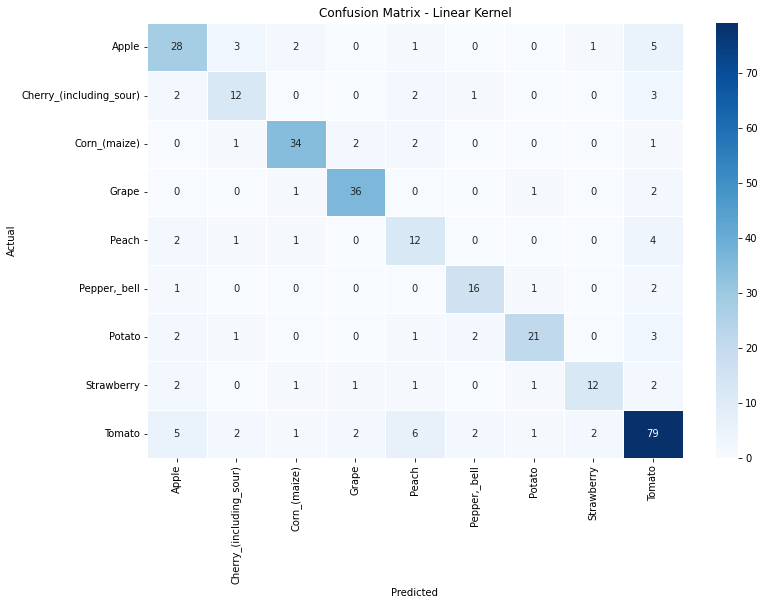

In [71]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_images, train_labels)
predicted_labels_linear = svm_classifier.predict(val_images)
accuracy_linear = accuracy_score(val_labels, predicted_labels_linear)
print("Accuracy using Linear Kernel:", accuracy_linear)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_linear, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Confusion Matrix - Linear Kernel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy using RBF Kernel: 0.8121212121212121


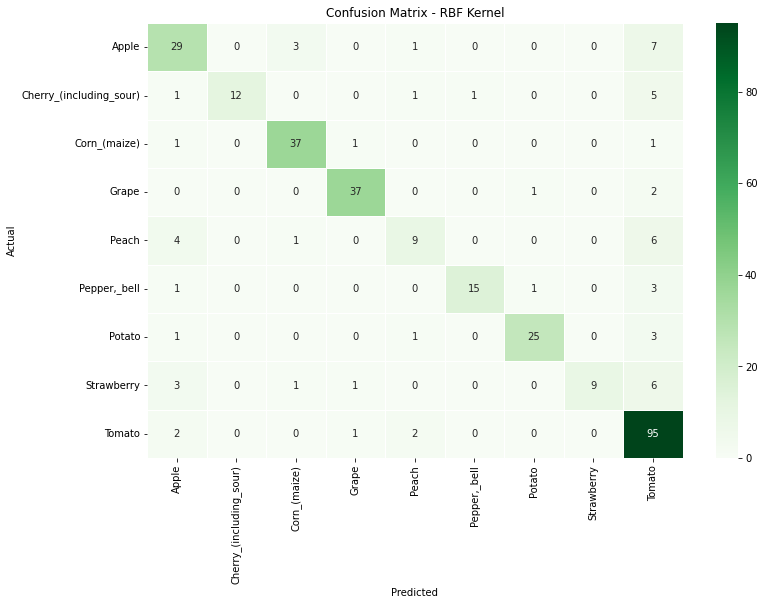

In [72]:
svm_rbf = SVC(kernel='rbf', gamma=0.1)
svm_rbf.fit(train_images, train_labels)
predicted_labels_rbf = svm_rbf.predict(val_images)
accuracy_rbf = accuracy_score(val_labels, predicted_labels_rbf)
print("Accuracy using RBF Kernel:", accuracy_rbf)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_rbf, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens', linewidths=0.5)
plt.title("Confusion Matrix - RBF Kernel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.6151515151515151


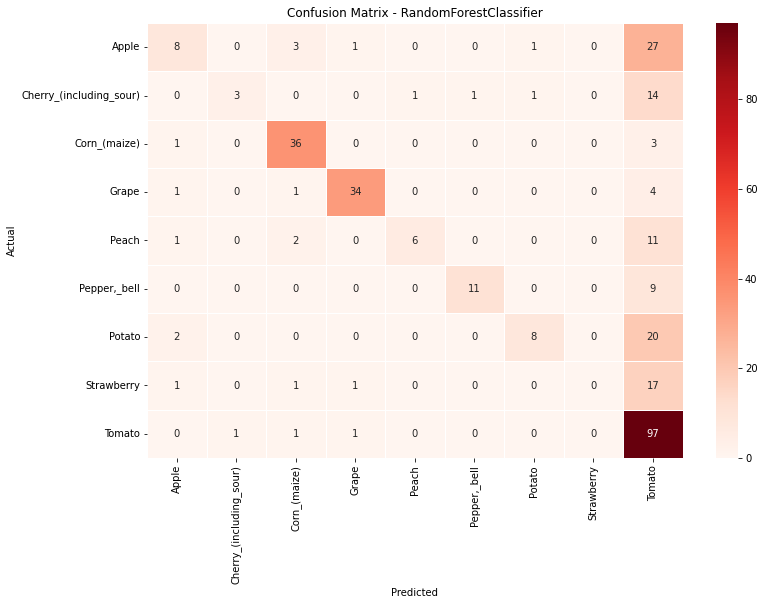

In [73]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(val_labels)

rf_model = RandomForestClassifier(n_estimators=1000, bootstrap=True, random_state=42)
rf_model.fit(train_images, train_labels_encoded)

test_predictions = rf_model.predict(val_images)

test_predictions_decoded = label_encoder.inverse_transform(test_predictions)
test_labels_decoded = label_encoder.inverse_transform(test_labels_encoded)

print("Accuracy:", accuracy_score(test_labels_decoded, test_predictions_decoded))

plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, test_predictions_decoded, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Reds', linewidths=0.5)
plt.title("Confusion Matrix - RandomForestClassifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Sift Feature Extraction**

In [74]:
def train_kmeans_bow(image_paths, num_clusters=50):
    sift = cv2.SIFT_create()
    all_descriptors = []

    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        _, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)

    all_descriptors = np.vstack(all_descriptors).astype(np.float32)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(all_descriptors)

    return kmeans

def getfeatures_sift(image_path, kmeans_model, num_clusters=50):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(image, None)

    bow_vector = np.zeros(num_clusters, dtype=np.float32)
    if descriptors is not None:
        closest_clusters = kmeans_model.predict(descriptors)
        for cluster_idx in closest_clusters:
            bow_vector[cluster_idx] += 1

    return bow_vector

In [75]:
num_clusters = 50
kmeans_bow = train_kmeans_bow(list(train_img_label_map.keys()), num_clusters=num_clusters)

In [76]:
train_images = np.array([getfeatures_sift(img_path, kmeans_bow, num_clusters=num_clusters)
                         for img_path in train_img_label_map.keys()])
train_labels = np.array(list(train_img_label_map.values()))

val_images = np.array([getfeatures_sift(img_path, kmeans_bow, num_clusters=num_clusters)
                       for img_path in val_img_label_map.keys()])
val_labels = np.array(list(val_img_label_map.values()))


Accuracy using Linear Kernel: 0.6303030303030303


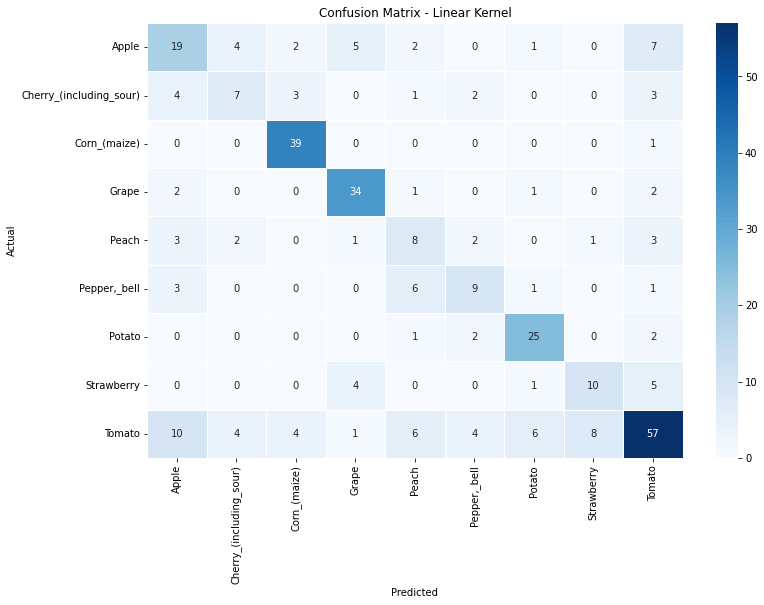

In [77]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_images, train_labels)
predicted_labels_linear = svm_classifier.predict(val_images)
accuracy_linear = accuracy_score(val_labels, predicted_labels_linear)
print("Accuracy using Linear Kernel:", accuracy_linear)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_linear, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Confusion Matrix - Linear Kernel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy using RBF Kernel: 0.7424242424242424


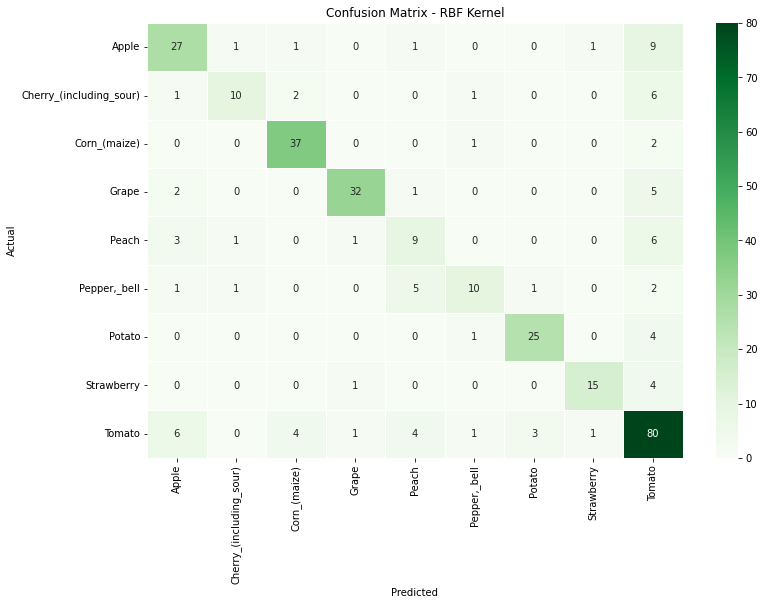

In [78]:
svm_rbf = SVC(kernel='rbf', gamma=0.001)
svm_rbf.fit(train_images, train_labels)
predicted_labels_rbf = svm_rbf.predict(val_images)
accuracy_rbf = accuracy_score(val_labels, predicted_labels_rbf)
print("Accuracy using RBF Kernel:", accuracy_rbf)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_rbf, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens', linewidths=0.5)
plt.title("Confusion Matrix - RBF Kernel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.6696969696969697


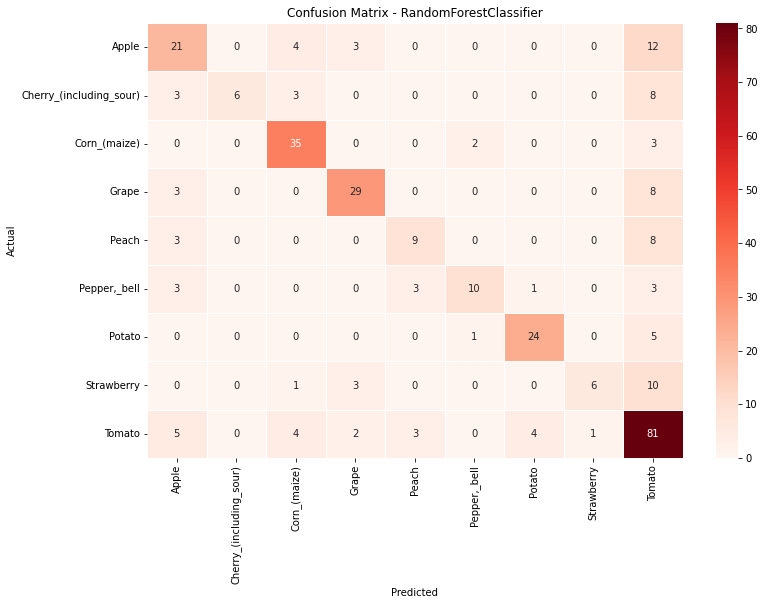

In [79]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(val_labels)

rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(train_images, train_labels_encoded)

test_predictions = rf_model.predict(val_images)

test_predictions_decoded = label_encoder.inverse_transform(test_predictions)
test_labels_decoded = label_encoder.inverse_transform(test_labels_encoded)

print("Accuracy:", accuracy_score(test_labels_decoded, test_predictions_decoded))

plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, test_predictions_decoded, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Reds', linewidths=0.5)
plt.title("Confusion Matrix - RandomForestClassifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Hog with PCA Feature Extraction**

In [80]:
def getfeatures(image_path):
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)
    image_resized = resize(image_gray, (128, 64))
    fd, _ = hog(image_resized, orientations=16, pixels_per_cell=(16, 16),
                cells_per_block=(2, 2), visualize=True)
    return fd

def fit_pca(train_img_label_map):
    all_features = [getfeatures(img_path) for img_path in train_img_label_map.keys()]
    all_features = np.array(all_features)
    pca = PCA(n_components=50)
    pca.fit(all_features)
    return pca

pca = fit_pca(train_img_label_map)

def getfeatures_pca_Hog(image_path):
    features = getfeatures(image_path)
    reduced_features = pca.transform([features])[0]
    return reduced_features

In [81]:
train_images = np.array([getfeatures_pca_Hog(img_path) for img_path in train_img_label_map.keys()])
train_labels = np.array(list(train_img_label_map.values()))

val_images = np.array([getfeatures_pca_Hog(img_path) for img_path in val_img_label_map.keys()])
val_labels = np.array(list(val_img_label_map.values()))

Accuracy using Linear Kernel: 0.7454545454545455


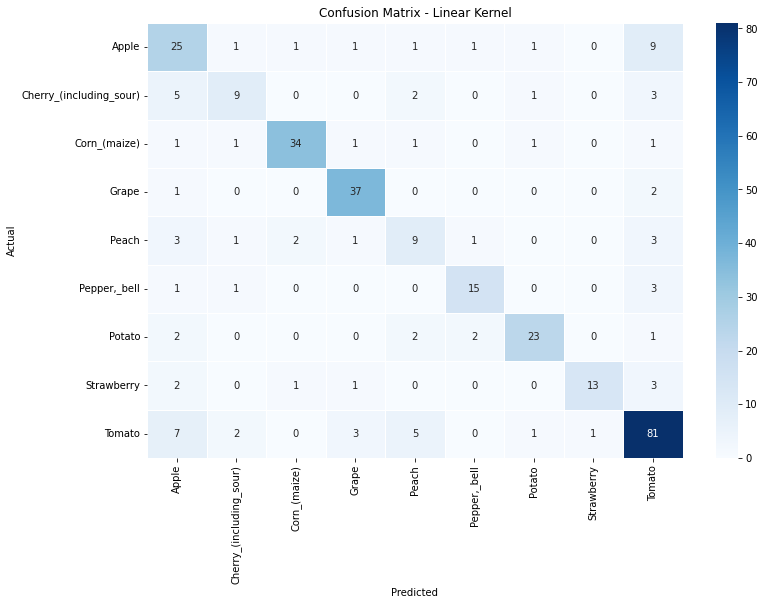

In [82]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_images, train_labels)
predicted_labels_linear = svm_classifier.predict(val_images)
accuracy_linear = accuracy_score(val_labels, predicted_labels_linear)
print("Accuracy using Linear Kernel:", accuracy_linear)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_linear, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Confusion Matrix - Linear Kernel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy using RBF Kernel: 0.7727272727272727


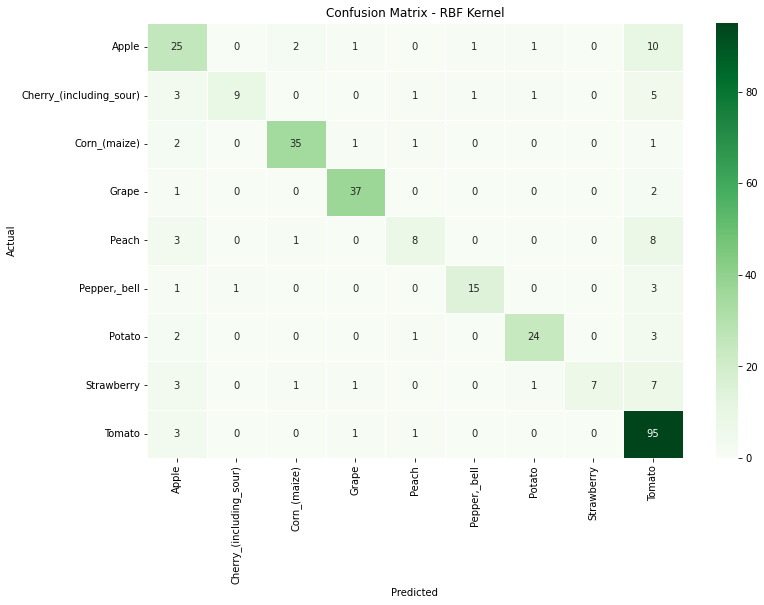

In [85]:
svm_rbf = SVC(kernel='rbf', gamma=0.1)
svm_rbf.fit(train_images, train_labels)
predicted_labels_rbf = svm_rbf.predict(val_images)
accuracy_rbf = accuracy_score(val_labels, predicted_labels_rbf)
print("Accuracy using RBF Kernel:", accuracy_rbf)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_rbf, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens', linewidths=0.5)
plt.title("Confusion Matrix - RBF Kernel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy using Logistic Regression: 0.7484848484848485


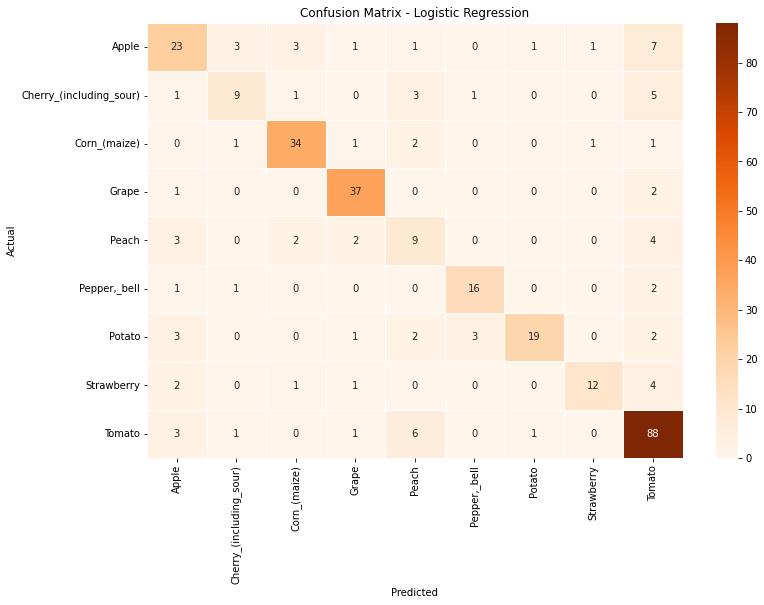

In [83]:
model = LogisticRegression(max_iter=1000)
model.fit(train_images, train_labels)
predicted_labels_linear = model.predict(val_images)
accuracy_linear = accuracy_score(val_labels, predicted_labels_linear)
print("Accuracy using Logistic Regression:", accuracy_linear)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_linear, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Oranges', linewidths=0.5)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy using xgboost: 0.7606060606060606


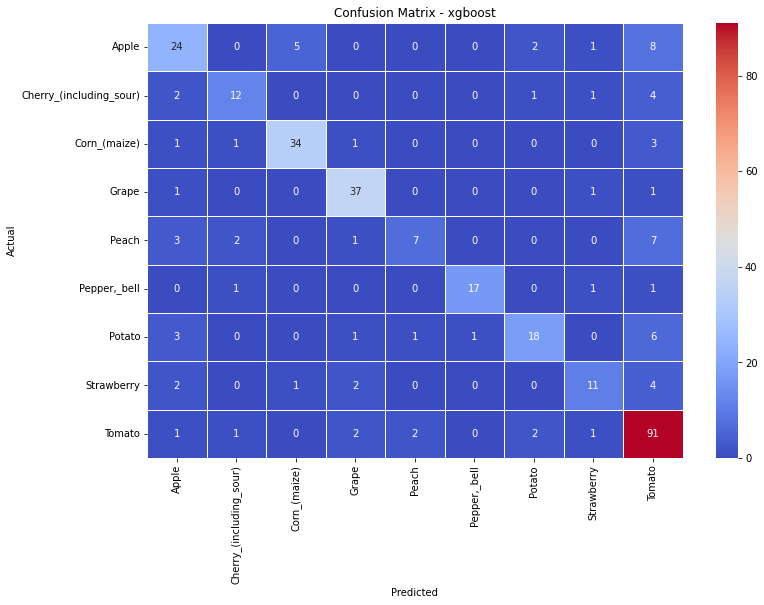

In [84]:
model = xgb.XGBClassifier(n_estimators=100)
model.fit(train_images, train_labels)
predicted_labels_linear = model.predict(val_images)
accuracy_linear = accuracy_score(val_labels, predicted_labels_linear)
print("Accuracy using xgboost:", accuracy_linear)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_linear, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title("Confusion Matrix - xgboost")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **PCA With Canny and Sobel Feature Extraction**

In [86]:
pca = PCA(n_components=100)

def Canny_Sobel(image_path):
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)


    image_resized = resize(image_gray, (128, 64))

    sobel_edges = sobel(image_resized)
    canny_edges = canny(image_resized)

    sobel_features = sobel_edges.flatten()
    canny_features = canny_edges.flatten()

    combined_features = np.concatenate([sobel_features, canny_features])
    return combined_features

pca.fit(np.array([Canny_Sobel(img_path) for img_path in train_img_label_map.keys()])) # Fit pca using Canny_Sobel features

def getfeatures_Pca_cannysobel(image_path):
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)

    image_resized = resize(image_gray, (128, 64))

    sobel_edges = sobel(image_resized)
    canny_edges = canny(image_resized)

    sobel_features = sobel_edges.flatten()
    canny_features = canny_edges.flatten()

    combined_features = np.concatenate([sobel_features, canny_features])

    reduced_features = pca.transform([combined_features])[0]

    return reduced_features

In [87]:
train_images = np.array([getfeatures_Pca_cannysobel(img_path) for img_path in train_img_label_map.keys()])
train_labels = np.array(list(train_img_label_map.values()))

val_images = np.array([getfeatures_Pca_cannysobel(img_path) for img_path in val_img_label_map.keys()])
val_labels = np.array(list(val_img_label_map.values()))

Accuracy using Linear Kernel: 0.503030303030303


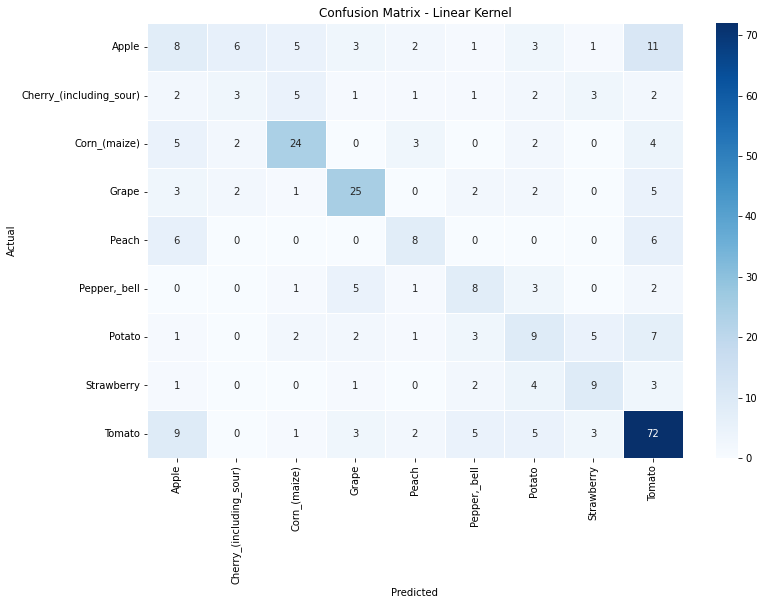

In [88]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_images, train_labels)
predicted_labels_linear = svm_classifier.predict(val_images)
accuracy_linear = accuracy_score(val_labels, predicted_labels_linear)
print("Accuracy using Linear Kernel:", accuracy_linear)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_linear, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Confusion Matrix - Linear Kernel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy using MLP: 0.5909090909090909


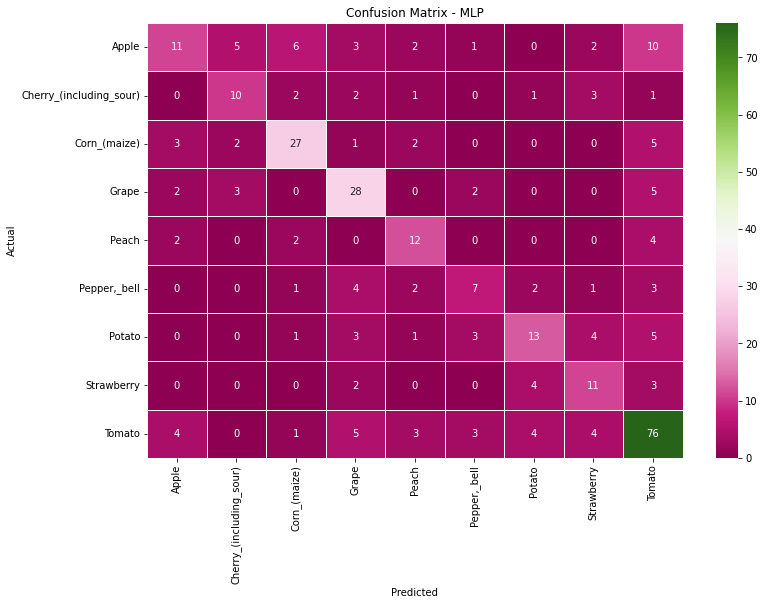

In [89]:
model = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=1000)
model.fit(train_images, train_labels)
predicted_labels_linear = model.predict(val_images)
accuracy_linear = accuracy_score(val_labels, predicted_labels_linear)
print("Accuracy using MLP:", accuracy_linear)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_linear, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='PiYG', linewidths=0.5)
plt.title("Confusion Matrix - MLP")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy using KNN: 0.44242424242424244


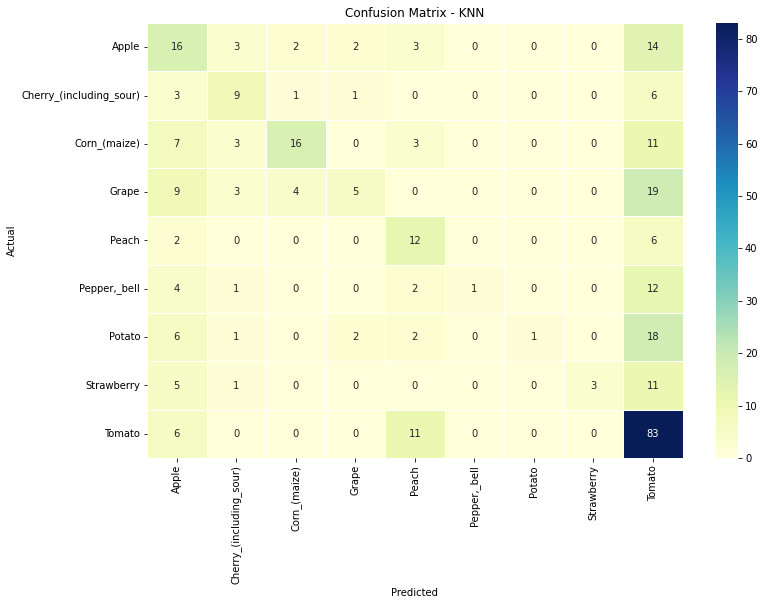

In [90]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_images, train_labels)
predicted_labels_linear = model.predict(val_images)
accuracy_linear = accuracy_score(val_labels, predicted_labels_linear)
print("Accuracy using KNN:", accuracy_linear)
#confussion matrix
plant_type_names = sorted(list(plant_type_mapping.keys()))
unique_labels = list(range(len(plant_type_names)))
class_names = [plant_type_names[label] for label in unique_labels]
cm = confusion_matrix(val_labels, predicted_labels_linear, labels=unique_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
plt.title("Confusion Matrix - KNN")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **Stage 2**

# **Reading the Dataset**

In [ ]:
# def load_images_and_create_map(directory, plant_type_mapping):
#     img_label_map = {}

#     label_encoder = LabelEncoder()
#     label_encoder.fit(list(plant_type_mapping.keys()))


#     for plant_type, disease_folders in plant_type_mapping.items():

#         for disease_folder in disease_folders:
#             disease_folder_path = os.path.join(directory, disease_folder)

#             for img_name in os.listdir(disease_folder_path):
#                 img_path = os.path.join(disease_folder_path, img_name)

#                 if os.path.isfile(img_path):

#                     label = label_encoder.transform([plant_type])[0]

#                     img_label_map[img_path] = label

#     return img_label_map

# # change this with you path on drive
# train_dir = '/kaggle/input/data-vision2/Project Data/Train/images/'
# val_dir = '/kaggle/input/data-vision2/Project Data/Val/images/'

# plant_type_mapping = {
#     "Apple": ["Apple___Apple_scab", "Apple___Black_rot", "Apple___Cedar_apple_rust", "Apple___healthy"],
#     "Cherry_(including_sour)": ["Cherry_(including_sour)___healthy", "Cherry_(including_sour)___Powdery_mildew"],
#     "Corn_(maize)": ["Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", "Corn_(maize)___Common_rust_", "Corn_(maize)___healthy", "Corn_(maize)___Northern_Leaf_Blight"],
#     "Grape": ["Grape___Black_rot", "Grape___Esca_(Black_Measles)", "Grape___healthy", "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)"],
#     "Peach": ["Peach___Bacterial_spot", "Peach___healthy"],
#     "Pepper,_bell": ["Pepper,_bell___Bacterial_spot", "Pepper,_bell___healthy"],
#     "Potato": ["Potato___Early_blight", "Potato___healthy", "Potato___Late_blight"],
#     "Strawberry": ["Strawberry___healthy", "Strawberry___Leaf_scorch"],
#     "Tomato": ["Tomato___Bacterial_spot", "Tomato___Early_blight", "Tomato___healthy", "Tomato___Late_blight",
#                "Tomato___Leaf_Mold", "Tomato___Septoria_leaf_spot", "Tomato___Spider_mites Two-spotted_spider_mite",
#                "Tomato___Target_Spot", "Tomato___Tomato_mosaic_virus", "Tomato___Tomato_Yellow_Leaf_Curl_Virus"]
# }

# train_img_label_map = load_images_and_create_map(train_dir, plant_type_mapping)
# print("Training dataset mapping length:", len(train_img_label_map))

# val_img_label_map = load_images_and_create_map(val_dir, plant_type_mapping)
# print("Validation dataset mapping length:", len(val_img_label_map))

# def preprocess_image(image_path):
#     img = load_img(image_path, target_size=(256, 256))
#     img_array = img_to_array(img)
#     img_array = img_array / 255.0
#     return img_array

# train_images = np.array([preprocess_image(img_path) for img_path in train_img_label_map.keys()])
# train_labels = np.array(list(train_img_label_map.values()))
# print(train_images.shape)

# val_images = np.array([preprocess_image(img_path) for img_path in val_img_label_map.keys()])
# val_labels = np.array(list(val_img_label_map.values()))
# print(val_labels.shape)

# train_labels = to_categorical(train_labels, num_classes=9)
# val_labels = to_categorical(val_labels, num_classes=9)
# print(train_labels.shape)

# train_datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
# )

# train_datagen.fit(train_images)
# val_datagen = ImageDataGenerator()

# train_generator = train_datagen.flow(train_images, train_labels, batch_size=64)
# val_generator = val_datagen.flow(val_images, val_labels, batch_size=64)

# print("done")

In [96]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

# ROOT = "/kaggle/input/data-vision2/Project Data/Train"
# def read_image(index):
#     path = os.path.join(index[0], index[1])
#     image = cv2.imread(path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     return image

def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

## Creating Triplets

In [97]:
def create_paths(directory):
  image_paths = {}
  for plant_type in plant_type_mapping.values():
    for plant_disease in plant_type:
      folder_path = os.path.join(directory, plant_disease)
      image_paths[plant_disease] = [
        os.path.join(folder_path, file)
        for file in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, file))
      ]

  return image_paths
print("done")

done


In [98]:
train_image_paths = create_paths(train_dir)
val_image_paths = create_paths(val_dir)
print("done")

done


In [ ]:
# def create_triplets(image_paths, max_files=10):
#     triplets = []
#     # folders = list(folder_list.keys())

#     # plant_type_mapping key -> plant, value -> List[folder name]
#     # len(plant_type_mapping) = 9 (aka. 9 plants)
#     # on each plant type we generate a, p, n -> with the same plant type. a, p with the same plant disease but not n (another random disease)
#     # so, loop on each type
#     # then on each plant type loop on the images on each folder path of the same plant type (plant_type_mapping.values)
#     # take a, p with the same disease but not n (while neg_folder == folder)
#     for plant_type in plant_type_mapping.values():
#       for plant_disease in plant_type:
#         num_files = min(max_files, len(image_paths[plant_disease]))
#         # print("plantdess",plant_disease)
#         for i in range(num_files-1):
#             for j in range(i+1, num_files):
#                 anchor = image_paths[plant_disease][i]
#                 positive = image_paths[plant_disease][j]

#                 neg_folder = plant_disease
#                 while neg_folder == plant_disease:
#                     neg_folder_key = random.choice(list(plant_type_mapping.keys()))  # Randomly choose a key
#                     neg_folder = random.choice(plant_type_mapping[neg_folder_key])
#                 neg_idx = random.randint(0, min(max_files, len(image_paths[neg_folder])) - 1)
#                 negative = image_paths[neg_folder][neg_idx]
#                 # print("negative",neg_folder)
#                 triplets.append((anchor, positive, negative))


#     # for folder in folders:
#     #     path = os.path.join(directory, folder)
#     #     files = list(os.listdir(path))[:]
#     #     num_files = len(files)

#     #     for i in range(num_files-1):
#     #         for j in range(i+1, num_files):
#     #             anchor = (folder, f"{i}.jpg")
#     #             positive = (folder, f"{j}.jpg")

#     #             neg_folder = folder
#     #             while neg_folder == folder:
#     #                 neg_folder = random.choice(folders)
#     #             neg_file = random.randint(0, folder_list[neg_folder]-1)
#     #             negative = (neg_folder, f"{neg_file}.jpg")

#     #             triplets.append((anchor, positive, negative))

#     random.shuffle(triplets)
#     return triplets

# train_triplet = create_triplets(train_image_paths)
# val_triplet  = create_triplets(val_image_paths)
# print("done")

In [ ]:
# import random

# def create_triplets(image_paths, max_files=10):
#     triplets = []

#     # Iterate through plant types in the mapping
#     for plant_type, diseases in plant_type_mapping.items():
#         for plant_disease in diseases:
#             num_files = min(max_files, len(image_paths[plant_disease]))

#             for i in range(num_files - 1):
#                 for j in range(i + 1, num_files):
#                     # Anchor and Positive: Same disease
#                     anchor = image_paths[plant_disease][i]
#                     positive = image_paths[plant_disease][j]

#                     # Negative: Same plant type but different disease
#                     neg_disease = plant_disease
#                     while neg_disease == plant_disease:
#                         neg_disease = random.choice(diseases)  # Choose a different disease within the same plant type

#                     neg_idx = random.randint(0, min(max_files, len(image_paths[neg_disease])) - 1)
#                     negative = image_paths[neg_disease][neg_idx]

#                     # Add the triplet
#                     triplets.append((anchor, positive, negative))

#     # Shuffle the triplets before returning
#     random.shuffle(triplets)
#     return triplets

# # Example usage
# train_triplet = create_triplets(train_image_paths)
# val_triplet = create_triplets(val_image_paths)
# print("done")


In [99]:
import random

def create_triplets(image_paths, plant_type_mapping, max_files=40, same_plant_type_prob=0.5):
    triplets = []

    for plant_type, diseases in plant_type_mapping.items():
        for plant_disease in diseases:
            num_files = min(max_files, len(image_paths[plant_disease]))

            for i in range(num_files - 1):
                for j in range(i + 1, num_files):
                    anchor = image_paths[plant_disease][i]
                    positive = image_paths[plant_disease][j]

                    if random.random() < same_plant_type_prob:
                        neg_disease = plant_disease
                        while neg_disease == plant_disease:
                            neg_disease = random.choice(diseases)
                    else:
                        neg_plant_type = plant_type
                        while neg_plant_type == plant_type:
                            neg_plant_type = random.choice(list(plant_type_mapping.keys()))
                        neg_disease = random.choice(plant_type_mapping[neg_plant_type])

                    neg_idx = random.randint(0, min(max_files, len(image_paths[neg_disease])) - 1)
                    negative = image_paths[neg_disease][neg_idx]

                    triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

train_triplet = create_triplets(train_image_paths, plant_type_mapping)
val_triplet = create_triplets(val_image_paths, plant_type_mapping)
print("done")

done


In [ ]:
# def create_triplets(image_paths, max_files=10):
#     triplets = []
#     # folders = list(folder_list.keys())

#     # plant_type_mapping key -> plant, value -> List[folder name]
#     # len(plant_type_mapping) = 9 (aka. 9 plants)
#     # on each plant type we generate a, p, n -> with the same plant type. a, p with the same plant disease but not n (another random disease)
#     # so, loop on each type
#     # then on each plant type loop on the images on each folder path of the same plant type (plant_type_mapping.values)
#     # take a, p with the same disease but not n (while neg_folder == folder)
#     cnt = 0
#     for plant_key, plant_type in plant_type_mapping.items():
#       for plant_disease in plant_type:
#         # num_files = min(max_files, len(image_paths[plant_disease]))
#         num_files = len(image_paths[plant_disease])
#         # print("plantdess",plant_disease)
#         for i in range(num_files-1):
#             for j in range(i+1, num_files):
#                 anchor = image_paths[plant_disease][i]
#                 positive = image_paths[plant_disease][j]
#                 if cnt >= 7:
#                     neg_folder = plant_disease
#                     while neg_folder == plant_disease or plant_key == neg_folder_key:
#                         neg_folder_key = random.choice(list(plant_type_mapping.keys()))  # Randomly choose a key
#                         neg_folder = random.choice(plant_type_mapping[neg_folder_key])
#                     neg_idx = random.randint(0, min(max_files, len(image_paths[neg_folder])) - 1)
#                     negative = image_paths[neg_folder][neg_idx]
#                     triplets.append((anchor, positive, negative))

#                 else:
#                     neg_folder = plant_disease
#                     while neg_folder == plant_disease:
#                         neg_folder = random.choice(plant_type)
#                     neg_idx = random.randint(0, min(max_files, len(image_paths[neg_folder])) - 1)
#                     negative = image_paths[neg_folder][neg_idx]
#                     triplets.append((anchor, positive, negative))
#                 cnt = (cnt + 1)%10

#     random.shuffle(triplets)
#     return triplets

# train_triplet = create_triplets(train_image_paths)
# val_triplet  = create_triplets(val_image_paths)
# print("done")

## Creating Batch-Generator¶

In [101]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])
print("done")

done


## Plotting the Data

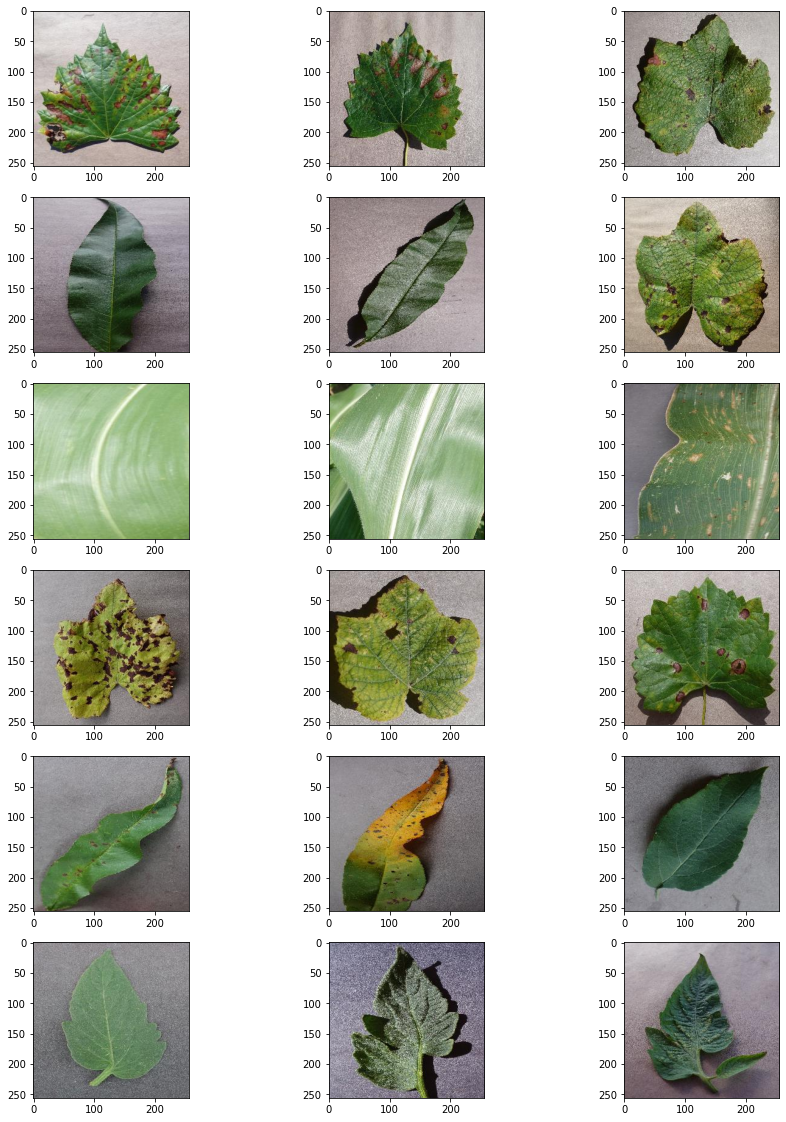

In [102]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Encoder

In [5]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = DenseNet121(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [104]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (256, 256, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          7695680     Anchor_Input[0][0]               
                                                                 Positive_Input[0][0

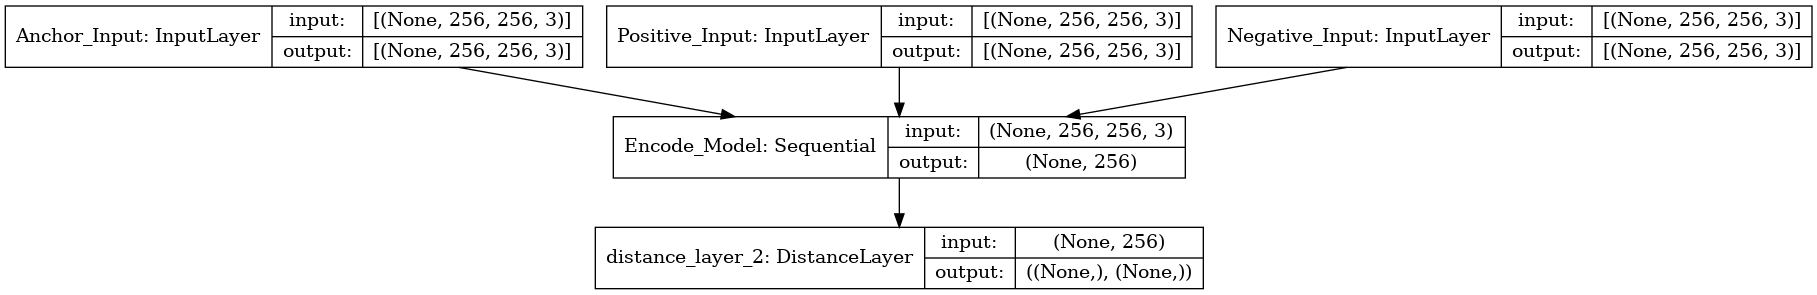

In [105]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [106]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [107]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

#siamese_model.build(input_shape=(128, 256, 256, 3))

## Training the Model
### Test Function

In [108]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(val_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [109]:
save_all = False
epochs = 10
batch_size = 64

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        # siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
# siamese_model.save_weights("siamese_model-detection.h5")


EPOCH: 1 	 (Epoch done in 533 sec)
Loss on train    = 0.19164
Accuracy on test = 0.93333

EPOCH: 2 	 (Epoch done in 584 sec)
Loss on train    = 0.05213
Accuracy on test = 0.95556

EPOCH: 3 	 (Epoch done in 588 sec)
Loss on train    = 0.02908
Accuracy on test = 0.95758

EPOCH: 4 	 (Epoch done in 581 sec)
Loss on train    = 0.01074
Accuracy on test = 0.95623

EPOCH: 5 	 (Epoch done in 579 sec)
Loss on train    = 0.00490
Accuracy on test = 0.94680

EPOCH: 6 	 (Epoch done in 531 sec)
Loss on train    = 0.00181
Accuracy on test = 0.94680

EPOCH: 7 	 (Epoch done in 529 sec)
Loss on train    = 0.00523
Accuracy on test = 0.93064

EPOCH: 8 	 (Epoch done in 580 sec)
Loss on train    = 0.00362
Accuracy on test = 0.94815

EPOCH: 9 	 (Epoch done in 582 sec)
Loss on train    = 0.00106
Accuracy on test = 0.94276

EPOCH: 10 	 (Epoch done in 530 sec)
Loss on train    = 0.00491
Accuracy on test = 0.95892


## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for later use.

In [110]:
def extract_encoder(model):
    encoder = get_encoder((256, 256, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("siamese_model-detection.h5")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
lambda_4 (Lambda)            (None, 256)               0         
Total params: 7,695,680
Trainable params: 1,181,824
Non-trainable params: 6,513,856
____________________________________

In [113]:
def classify_images(list1,list2,encoder = encoder, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(list1)
    tensor2 = encoder.predict(list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.91015625



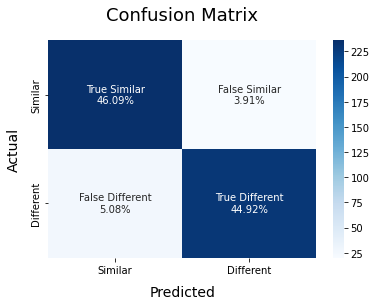

In [114]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(val_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

# ** My Test Script using 2 Models **

* classification Model called : loaded_model
* detection Model called : encoder

In [6]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/kaggle/input/calssification_model_computervision/other/default/1/new_model.h5')


# Input shape for the encoder model
input_shape = (256, 256, 3)
encoder = get_encoder(input_shape)
encoder.load_weights("/kaggle/input/detection_model_computervision/other/default/1/siamese_model-detection.h5")

29097984/29084464 [==============================] - 0s 0us/step


In [7]:
import os
import tensorflow as tf
import numpy as np
from flask import Flask, request, render_template
from werkzeug.utils import secure_filename
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# model = tf.keras.models.load_model("/kaggle/working/new_model.h5")

def Testimage(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array
    
def predict_plant_type(image_path):
    img_array = Testimage(image_path)
    # print(img_array.shape)
    prediction = loaded_model.predict(img_array)  # Predict the class probabilities
    predicted_class = np.argmax(prediction, axis=1)  # Get the index of the highest probability
    try:
        plant_type = list(plant_type_mapping.keys())[predicted_class[0]]  # Map index to plant type
    except:
        return "No Info"
    return plant_type

# basepath = os.path.dirname(file)
# file_path = os.path.join(basepath, 'uploads', secure_filename(f.filename))


predicted_plant_type = predict_plant_type("/kaggle/input/data-vision2/Project Data/Val/images/Apple___Apple_scab/0cbfa4fa-63d8-43ce-9385-ff140e524b69___FREC_Scab 3164.JPG")
print(predicted_plant_type)  # Return the predicted label

Apple


In [8]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))  # Resize to required size
    img_array = img_to_array(img)  # Convert image to array
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def load_one_image_from_folder(folder_path):
    # print(f"Checking folder: {folder_path}")
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        return preprocess_image(image_path)



def predict_disease(image_path, base_folder, encoder):
    # Step 1: Predict plant type
    plant_type = predict_plant_type(image_path)
    if plant_type not in plant_type_mapping:
        return plant_type, "Unknown"

    folders = plant_type_mapping[plant_type]
    if not folders:
        return plant_type, "Unknown"

    # Step 3: Load the input image and encode it using the encoder model
    input_image = preprocess_image(image_path)
    input_embedding = encoder.predict(input_image)

    # Step 4: Compare with one-shot images using encoder embeddings
    min_distance = float("inf")
    predicted_disease = "Unknown"

    for folder in folders:
        folder_path = os.path.join(base_folder, folder, "")
        try:
            # Load all images in the folder and compute average embedding
            embeddings = []
            for filename in os.listdir(folder_path):
                one_shot_image_path = os.path.join(folder_path, filename)
                one_shot_image = preprocess_image(one_shot_image_path)
                one_shot_embedding = encoder.predict(one_shot_image)
                embeddings.append(one_shot_embedding)
            
            if embeddings:
                avg_embedding = np.mean(embeddings, axis=0)
                distance = np.sum(np.square(input_embedding - avg_embedding), axis=-1)
                if distance < min_distance:
                    min_distance = distance
                    predicted_disease = folder
        except Exception as e:
            # print(f"Error processing folder {folder_path}: {e}")
            continue

    return plant_type, predicted_disease

# Example usage
base_folder = "/kaggle/input/data-vision2/Project Data/Train/images/"
image_path = "/kaggle/input/data-vision2/Project Data/Train/images/Pepper,_bell___healthy/03138bf7-1441-4df8-88a2-7e71b84f6bf0___JR_HL 5823.JPG"

# # Load your pre-trained encoder model
# encoder_model = tf.keras.models.load_model("/path/to/encoder_model.h5")  # Update with the path to your encoder model

predicted_disease = predict_disease(image_path, base_folder, encoder)
print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: ('Pepper,_bell', 'Pepper,_bell___healthy')


# **Test script 1**

# **Train data**

* Accuracy before changing triplets : Accuracy: 70.30%

In [ ]:
# import os
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# correct_predictions_plant = 0
# correct_predictions_disease = 0
# total_predictions = 0

# def get_accuracy(base_folder,encoder):
#     global correct_predictions_plant, total_predictions, correct_predictions_disease  # Declare the global variables
#     # Traverse through all subdirectories and files
#     for root, dirs, files in os.walk(base_folder):
#         for filename in files:
#             image_path = os.path.join(root, filename)  # Get the full image path
#             plant_type,predicted_disease = predict_disease(image_path, base_folder, encoder)
#             # Get the true label (plant type and disease)
#             folder_name = os.path.basename(root)
#             true_plant_type = folder_name.split("___")[0]
#             true_disease = folder_name
            
#             total_predictions += 1
#             # Compare predicted plant type with true plant type
#             if plant_type == true_plant_type:
#                 correct_predictions_plant += 1
                
#                 # Compare predicted disease with true disease
#                 if predicted_disease == true_disease:
#                     correct_predictions_disease += 1
#     # Calculate accuracies
#     accuracy_plant_type = correct_predictions_plant / total_predictions if total_predictions > 0 else 0
#     accuracy_disease = correct_predictions_disease / total_predictions if total_predictions > 0 else 0
#     return accuracy_plant_type ,accuracy_disease

# # Example usage
# base_folder = "/kaggle/input/data-vision2/Project Data/Train/images/"
# accuracy_plant_type,accuracy_disease = get_accuracy(base_folder, encoder)
# print(f"Accuracy for Plant Type Prediction: {accuracy_plant_type * 100:.2f}%")
# print(f"Accuracy for Disease Prediction: {accuracy_disease * 100:.2f}%")

# **Test data**

* Accuracy before changing triplets : Accuracy: 63.64%


In [121]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

correct_predictions_plant = 0
correct_predictions_disease = 0
total_predictions = 0

def get_accuracy(base_folder,encoder):
    global correct_predictions_plant, total_predictions, correct_predictions_disease  # Declare the global variables
    # Traverse through all subdirectories and files
    for root, dirs, files in os.walk(base_folder):
        for filename in files:
            image_path = os.path.join(root, filename)  # Get the full image path
            plant_type,predicted_disease = predict_disease(image_path, base_folder, encoder)
            # Get the true label (plant type and disease)
            folder_name = os.path.basename(root)
            true_plant_type = folder_name.split("___")[0]
            true_disease = folder_name

            total_predictions += 1
            # Compare predicted plant type with true plant type
            if plant_type == true_plant_type:
                correct_predictions_plant += 1
                
                # Compare predicted disease with true disease
                if predicted_disease == true_disease:
                    correct_predictions_disease += 1
            
    accuracy_plant_type = correct_predictions_plant / total_predictions if total_predictions > 0 else 0
    accuracy_disease = correct_predictions_disease / total_predictions if total_predictions > 0 else 0
    return accuracy_plant_type ,accuracy_disease

# Example usage
base_folder = "/kaggle/input/data-vision2/Project Data/Val/images/"
accuracy_plant_type,accuracy_disease = get_accuracy(base_folder, encoder)
print(f"Accuracy for Plant Type Prediction: {accuracy_plant_type * 100:.2f}%")
print(f"Accuracy for Disease Prediction: {accuracy_disease * 100:.2f}%")

Accuracy for Plant Type Prediction: 97.27%
Accuracy for Disease Prediction: 86.36%


# ** Test (testvision 1 & 2a) **

In [117]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

correct_predictions_plant = 0
correct_predictions_disease = 0
total_predictions = 0

def get_accuracy(base_folder,encoder):
    global correct_predictions_plant, total_predictions, correct_predictions_disease  # Declare the global variables
    # Traverse through all subdirectories and files
    for root, dirs, files in os.walk(base_folder):
        for filename in files:
            image_path = os.path.join(root, filename)  # Get the full image path
            plant_type,predicted_disease = predict_disease(image_path, base_folder, encoder)
            # print("plant type :",plant_type )
            # print("predicted disease :",predicted_disease )
            # Get the true label (plant type and disease)
            folder_name = os.path.basename(root)
            # print(folder_name)
            true_plant_type = folder_name.split("___")[0]
            true_disease = folder_name
            # print("true_plant type :",true_plant_type )
            # print("true_disease :",true_disease )
            
            total_predictions += 1
            # Compare predicted plant type with true plant type
            if plant_type == true_plant_type:
                # print("true palnt type" ,true_plant_type )
                correct_predictions_plant += 1
                
                # Compare predicted disease with true disease
                if predicted_disease == true_disease:
                    correct_predictions_disease += 1
    # print(correct_predictions_plant) 
    # print(correct_predictions_disease)
    # print(total_predictions)
    accuracy_plant_type = correct_predictions_plant / total_predictions if total_predictions > 0 else 0
    accuracy_disease = correct_predictions_disease / total_predictions if total_predictions > 0 else 0
    return accuracy_plant_type ,accuracy_disease

# Example usage
base_folder = "/kaggle/input/testvision/testvision/"
accuracy_plant_type,accuracy_disease = get_accuracy(base_folder, encoder)
print(f"Accuracy for Plant Type Prediction: {accuracy_plant_type * 100:.2f}%")
print(f"Accuracy for Disease Prediction: {accuracy_disease * 100:.2f}%")

Accuracy for Plant Type Prediction: 96.97%
Accuracy for Disease Prediction: 96.97%


# ** Test stage 2b **

In [118]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path):
    # Preprocess the image (resize, normalize, etc.)
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img) 
    img_array = img_array / 255.0 
    return img_array

def predict_disease(base_folder, encoder):
    # Define the anchor image
    anchor_image_path = os.path.join(base_folder, "Anchor.JPG")
    anchor_image = preprocess_image(anchor_image_path)
    anchor_embedding = encoder.predict(np.expand_dims(anchor_image, axis=0))  # Add batch dimension

    # Initialize the minimum distance and predicted disease
    min_distance = float("inf")
    predicted_disease = "Unknown"

    # Loop through all images in the folder
    for filename in os.listdir(base_folder):
        # Skip the anchor image itself
        if filename == "Anchor.JPG":
            continue

        image_path = os.path.join(base_folder, filename)
        image = preprocess_image(image_path)
        image_embedding = encoder.predict(np.expand_dims(image, axis=0)) 

        distance = np.sum(np.square(anchor_embedding - image_embedding), axis=-1)
        print(f"Distance to {filename}: {distance[0]}")

        if distance < min_distance:
            min_distance = distance
            predicted_disease = filename

    return predicted_disease

# Example usage
base_folder = "/kaggle/input/oloooooooo/test"  # Replace with your folder path
predicted_disease = predict_disease(base_folder, encoder)
print(f"Predicted Disease: {predicted_disease}")
# anchor ---> CornCommonRust1

Distance to TomatoEarlyBlight6.JPG: 1.3588322401046753
Distance to TomatoYellowCurlVirus4.JPG: 2.000000238418579
Distance to TomatoYellowCurlVirus6.JPG: 2.000000238418579
Distance to PotatoHealthy2.JPG: 2.000000238418579
Distance to TomatoYellowCurlVirus5.JPG: 2.0
Distance to PotatoEarlyBlight2.JPG: 1.1979032754898071
Distance to TomatoYellowCurlVirus3.JPG: 2.0
Distance to TomatoEarlyBlight3.JPG: 2.000000238418579
Distance to AppleScab3.JPG: 0.8966593146324158
Distance to TomatoEarlyBlight5.JPG: 2.000000238418579
Distance to TomatoHealthy2.JPG: 2.0
Distance to CornCommonRust1.JPG: 0.03513531759381294
Distance to PotatoEarlyBlight4.JPG: 0.8452602624893188
Distance to TomatoEarlyBlight2.JPG: 2.000000238418579
Distance to TomatoYellowCurlVirus2.JPG: 2.000000476837158
Distance to TomatoEarlyBlight4.JPG: 1.4360086917877197
Distance to AppleCedarRust3.JPG: 1.5403218269348145
Distance to TomatoHealthy3.JPG: 1.45148766040802
Distance to AppleScab1.JPG: 1.9282236099243164
Distance to TomatoHeal

# **Unseen Test**

Test 1

In [9]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

correct_predictions_plant = 0
correct_predictions_disease = 0
total_predictions = 0

def get_accuracy(base_folder,encoder):
    global correct_predictions_plant, total_predictions, correct_predictions_disease  # Declare the global variables
    # Traverse through all subdirectories and files
    for root, dirs, files in os.walk(base_folder):
        for filename in files:
            image_path = os.path.join(root, filename)  # Get the full image path
            plant_type,predicted_disease = predict_disease(image_path, base_folder, encoder)
            # print("plant type :",plant_type )
            # print("predicted disease :",predicted_disease )
            # Get the true label (plant type and disease)
            folder_name = os.path.basename(root)
            # print(folder_name)
            true_plant_type = folder_name.split("___")[0]
            true_disease = folder_name
            # print("true_plant type :",true_plant_type )
            # print("true_disease :",true_disease )
            
            total_predictions += 1
            # Compare predicted plant type with true plant type
            if plant_type == true_plant_type:
                # print("true palnt type" ,true_plant_type )
                correct_predictions_plant += 1
                
                # Compare predicted disease with true disease
                if predicted_disease == true_disease:
                    correct_predictions_disease += 1
    # print(correct_predictions_plant) 
    # print(correct_predictions_disease)
    # print(total_predictions)
    accuracy_plant_type = correct_predictions_plant / total_predictions if total_predictions > 0 else 0
    accuracy_disease = correct_predictions_disease / total_predictions if total_predictions > 0 else 0
    return accuracy_plant_type ,accuracy_disease

# Example usage
base_folder = "/kaggle/input/unseen-test1/Test samples for stage 1 (classification) and stage 2 (recognition)"
accuracy_plant_type,accuracy_disease = get_accuracy(base_folder, encoder)
print(f"Accuracy for Plant Type Prediction: {accuracy_plant_type * 100:.2f}%")
print(f"Accuracy for Disease Prediction: {accuracy_disease * 100:.2f}%")

Accuracy for Plant Type Prediction: 98.98%
Accuracy for Disease Prediction: 91.33%


Test 2

In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path):
    # Preprocess the image (resize, normalize, etc.)
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img) 
    img_array = img_array / 255.0 
    return img_array

def predict_disease(base_folder, encoder):
    # Define the anchor image
    anchor_image_path = os.path.join(base_folder, "Anchor.JPG")
    anchor_image = preprocess_image(anchor_image_path)
    anchor_embedding = encoder.predict(np.expand_dims(anchor_image, axis=0))  # Add batch dimension

    # Initialize the minimum distance and predicted disease
    min_distance = float("inf")
    predicted_disease = "Unknown"

    # Loop through all images in the folder
    for filename in os.listdir(base_folder):
        # Skip the anchor image itself
        if filename == "Anchor.JPG":
            continue

        image_path = os.path.join(base_folder, filename)
        image = preprocess_image(image_path)
        image_embedding = encoder.predict(np.expand_dims(image, axis=0)) 

        distance = np.sum(np.square(anchor_embedding - image_embedding), axis=-1)
        print(f"Distance to {filename}: {distance[0]}")

        if distance < min_distance:
            min_distance = distance
            predicted_disease = filename

    return predicted_disease

# Example usage
base_folder = "/kaggle/input/unseen-test2/One-few shot recognition part 2"  # Replace with your folder path
predicted_disease = predict_disease(base_folder, encoder)
print(f"Predicted Disease: {predicted_disease}")
# anchor --->

Distance to Squash_powdery_mildew.JPG: 1.704535961151123
Distance to Sobyean_healthy.JPG: 1.999999761581421
Distance to Potato_late_blight.JPG: 1.9851628541946411
Distance to Blueberry_healthy.JPG: 1.5673191547393799
Distance to Tomato_healthy.JPG: 1.999999761581421
Distance to Rasperry_healthy.JPG: 1.6955721378326416
Distance to Apple_scab.JPG: 0.4513995945453644
Distance to Blueberry_healthy2.JPG: 1.1625018119812012
Distance to Orange_citrus_greening.JPG: 1.999999761581421
Distance to Philodendron.png: 1.9999998807907104
Distance to Peach_Bacterial_spot.JPG: 1.9685218334197998
Distance to Hibisicus_plant_gudhal.png: 1.9999998807907104
Predicted Disease: Apple_scab.JPG
